In [1]:
import yaml
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
%matplotlib inline

from electronfactors import (
    create_model, create_green_cm, fit_give, to_eqPonA)

In [2]:
green_cm = create_green_cm()

In [3]:
from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'20'})
# rc('text', usetex=True)

rc('legend', fontsize=16)

In [4]:
use_low_res = True  # False

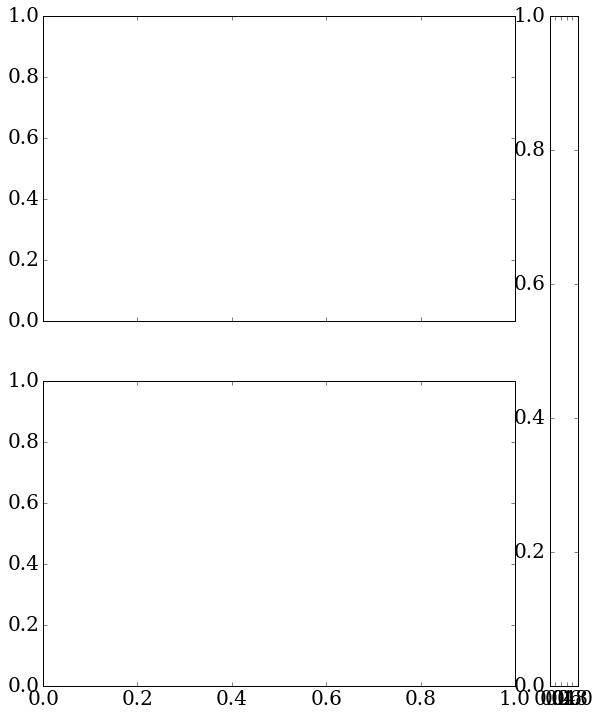

In [5]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(6*1.618, 6*2))

fig.subplots_adjust(right=0.80)
cbar_ax = fig.add_axes([0.85, 0.125, 0.04, 0.775])

In [6]:
with open("model_cache/12MeV_10app_100ssd.yml", 'r') as file:
    cutout_data = yaml.load(file)
    
label = np.array([key for key in cutout_data])
book_factor = np.array([item[0] == 'P' for i, item in enumerate(label)])

custom_label = label[~book_factor]

width = np.array([cutout_data[key]['width'] for key in custom_label])
length = np.array([cutout_data[key]['length'] for key in custom_label])
factor = np.array([cutout_data[key]['factor'] for key in custom_label])

perimeter = (
    np.pi / 2 * 
    (3*(width + length) - 
     np.sqrt((3*width + length)*(3*length + width))))
area = np.pi / 4 * width * length
eqPonA = perimeter / area

In [7]:
model = create_model(width, eqPonA, factor)

In [8]:
if use_low_res:
    x = np.arange(
        np.floor(np.min(width)) - 1,
        np.ceil(np.max(width)), 0.1)
    y = np.arange(
        np.floor(np.min(eqPonA)*10)/10 - 0.2,
        np.ceil(np.max(eqPonA)*10)/10 + 0.1, 0.02)

else:

    x = np.arange(
        np.floor(np.min(width)) - 1,
        np.ceil(np.max(width)), 0.01)
    y = np.arange(
        np.floor(np.min(eqPonA)*10)/10 - 0.2,
        np.ceil(np.max(eqPonA)*10)/10 + 0.1, 0.002)

xx, yy = np.meshgrid(x, y)

zz = model(xx, yy)
give_contour = fit_give(xx, yy, width, eqPonA, factor, kx=2, ky=1)

maximum_eqPonA = to_eqPonA(xx, xx)

mesh_max_area = ((10 * np.sqrt(2) - xx) * xx + (xx/np.sqrt(2))**2)
mesh_max_length = 4 * mesh_max_area / (np.pi * xx)

minimum_rqPonA = to_eqPonA(xx, mesh_max_length)

full_colour = give_contour < 0.5

full_colour_zz = zz.copy()
full_colour_zz[~full_colour] = np.nan


In [9]:
vmin = 0.92
vmax = 1.015

circle_bound_width = np.linspace(2, 10)
circle_bound_eqPonA = to_eqPonA(circle_bound_width, circle_bound_width)

max_eqPonA_width = np.linspace(2, 10)
max_area = (
    (10 * np.sqrt(2) - max_eqPonA_width) * 
    max_eqPonA_width + (max_eqPonA_width/np.sqrt(2))**2)
max_length = 4 * max_area / (np.pi * max_eqPonA_width)
max_eqPonA = to_eqPonA(max_eqPonA_width, max_length)


c = ax1.contourf(
    xx, yy, full_colour_zz, 40, alpha=1, 
    cmap=green_cm, vmin=vmin, vmax=vmax)
ax1.contour(
    xx, yy, full_colour_zz, 40, alpha=1, 
    cmap=green_cm, vmin=vmin, vmax=vmax)
colourbar = fig.colorbar(
    c, ticks=np.arange(0.90, 1.1, 0.01), 
    label=r'Insert factor', cax=cbar_ax)

norm = Normalize(vmin=vmin, vmax=vmax)

cb = ColorbarBase(
    cbar_ax, cmap=green_cm, alpha=1,
    norm=norm, label=r'Insert factor')

ax1.scatter(
    width, eqPonA, s=200, lw=2,
    c=factor, cmap=green_cm, 
    vmin=vmin, vmax=vmax,
    zorder=100)

ax1.scatter(
    [-1]*3, [-1]*3, s=200, lw=2,
    c=[green_cm(0.2), green_cm(0.5), green_cm(0.8)],
    zorder=100, 
    label=r'Measured 12 MeV data')


ax1.contour(xx, yy, give_contour, levels=[0.5], colors='k')
ax1.plot(3, 0.4, 'k-', label=r'Deformability boundary')

ax1.plot(
    circle_bound_width, circle_bound_eqPonA, 
    'k', lw=3, label=r'Circle bound', zorder=99)
ax1.plot(
    max_eqPonA_width, max_eqPonA, 'k--', 
    lw=3, label=r'Approx. applicator bound', zorder=99)

ax1.set_xlabel(r'Width (cm)')
ax1.set_ylabel(r'Perimeter / Area (cm$^{-1}$)')
ax1.set_xlim([2.4, 9.8])
ax1.set_ylim([0.36,1.4])

tk_all = ax1.get_xticklabels()
for tk in tk_all:
    tk.set_visible(True)

# fig


In [10]:
if use_low_res:
    x = np.arange(2.5, 10, 0.1)
    y = np.arange(2.5, 18, 0.2)
    
else:
    x = np.arange(2.5, 10, 0.01)
    y = np.arange(2.5, 18, 0.02)

mesh_width, mesh_length = np.meshgrid(x, y)

mesh_eqPonA = to_eqPonA(mesh_width, mesh_length)

width_length_zz = model(mesh_width, mesh_eqPonA)
give = fit_give(mesh_width, mesh_eqPonA, width, eqPonA, factor, kx=2, ky=1)


mesh_max_area = (
    (10 * np.sqrt(2) - mesh_width) * 
    mesh_width + (mesh_width/np.sqrt(2))**2)
mesh_max_length = 4 * mesh_max_area / (np.pi * mesh_width)

full_colour = give < 0.5

full_colour_width_length_zz = width_length_zz.copy()
full_colour_width_length_zz[~full_colour] = np.nan


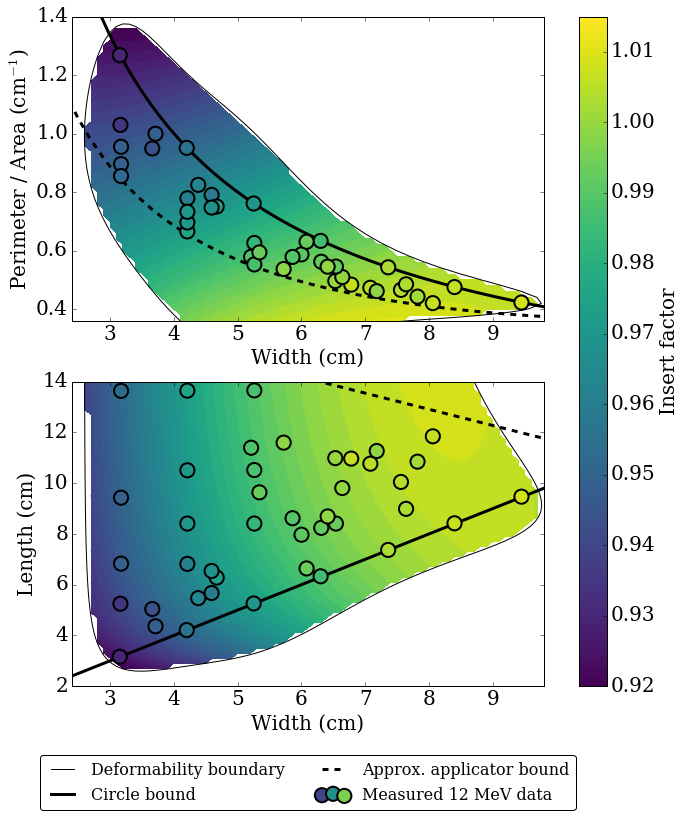

In [11]:
circle_bound_width = np.linspace(2, 11)

max_length_width = np.linspace(2, 11)
max_area = (
    (10 * np.sqrt(2) - max_length_width) * 
    max_length_width + (max_length_width/np.sqrt(2))**2)
max_length = 4 * max_area / (np.pi * max_length_width)


c = ax2.contourf(mesh_width, mesh_length, full_colour_width_length_zz, 40, 
                 alpha=1, cmap=green_cm, vmin=vmin, vmax=vmax)
ax2.contour(mesh_width, mesh_length, full_colour_width_length_zz, 40, 
                 alpha=1, cmap=green_cm, vmin=vmin, vmax=vmax)


ax2.scatter(
    width, length, s=200, lw=2,
    c=factor, cmap=green_cm, 
    vmin=vmin, vmax=vmax,
    zorder=3)

ax2.scatter(
    [-1]*3, [-1]*3, s=200, lw=2,
    c=[green_cm(0.2), green_cm(0.5), green_cm(0.8)],
    zorder=3, 
    label=r'Measured 12 MeV data')

ax2.contour(mesh_width, mesh_length, give, levels=[0.5], colors='k')
ax2.plot(3, 0.4, 'k-', label=r'Deformability boundary')

ax2.plot(
    circle_bound_width, circle_bound_width, 
    'k', lw=3, label=r'Circle bound', zorder=2)
ax2.plot(
    max_length_width, max_length, 
    'k--', lw=3, label=r'Approx. applicator bound', zorder=2)

ax2.set_xlabel(r'Width (cm)')
ax2.set_ylabel(r'Length (cm)')
ax2.set_xlim([2.4, 9.8])
ax2.set_ylim([2, 14])



ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, ncol=2)

# fig.savefig('figures/spline_fit.png', bbox_inches='tight', dpi=300)
# fig.savefig('figures/spline_fit.eps', bbox_inches='tight')

fig

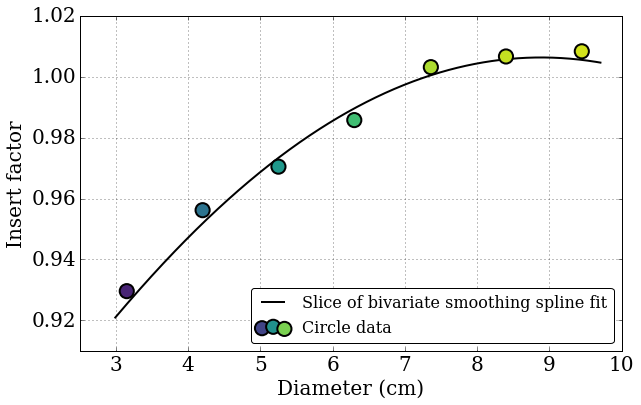

In [12]:
plt.figure(figsize=(6 * 1.618, 6))

circle_width = np.linspace(2,12, 1000)
circle_eqPonA = to_eqPonA(circle_width, circle_width)

give_circle = fit_give(
    circle_width, circle_eqPonA, 
    width, eqPonA, factor, kx=2, ky=1)
circle_width = circle_width[give_circle < 0.5]
circle_eqPonA = circle_eqPonA[give_circle < 0.5]

circle_prediction = model(circle_width, circle_eqPonA)
plt.plot(
    circle_width, circle_prediction, 
    'k', lw=2, label=r'Slice of bivariate smoothing spline fit')
circle_ref = np.abs(width - length) < 0.1

plt.scatter(
    width[circle_ref], factor[circle_ref], 
    s=200, lw=2,
    c=factor[circle_ref], cmap=green_cm, 
    vmin=vmin, vmax=vmax,
    zorder=3)

plt.scatter(
    [-1]*3, [-1]*3, s=200, lw=2,
    c=[green_cm(0.2), green_cm(0.5), green_cm(0.8)],
    zorder=3, 
    label=r'Circle data')

plt.xlim([2.5, 10])
plt.ylim([0.91, 1.02])

plt.xlabel('Diameter (cm)')
plt.ylabel('Insert factor')
legend = plt.legend(fancybox=True, loc='lower right')
legend.get_frame().set_facecolor('white')

plt.grid(True)

# plt.savefig('figures/circle_fit.png', bbox_inches='tight', dpi=300)
# plt.savefig('figures/circle_fit.eps', bbox_inches='tight')

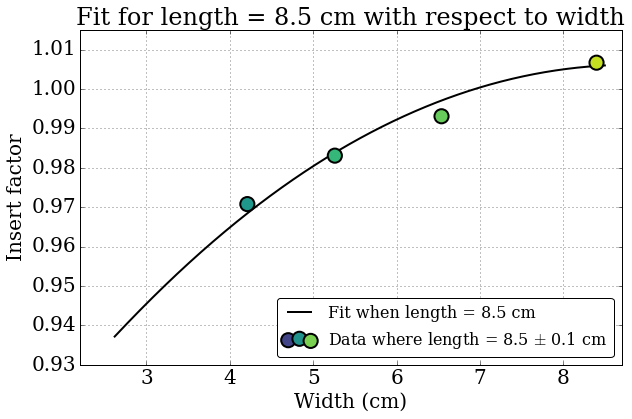

In [13]:
plt.figure(figsize=(6 * 1.618, 6))

specific_length = 8.5
specific_length = np.array([specific_length]*1000)

specific_length_width = np.linspace(2, specific_length[0], 1000)
specific_length_eqPonA = to_eqPonA(specific_length_width, specific_length)

give_specific_length = fit_give(
    specific_length_width, specific_length_eqPonA, width, eqPonA, factor, kx=2, ky=1)
specific_length_width = specific_length_width[give_specific_length < 0.5]
specific_length_eqPonA = specific_length_eqPonA[give_specific_length < 0.5]
specific_length = specific_length[give_specific_length < 0.5]

specific_length_prediction = model(
    specific_length_width, specific_length_eqPonA)
plt.plot(
    specific_length_width, specific_length_prediction, 
    'k', lw=2, label=r'Fit when length = 8.5 cm')

specific_length_ref = np.abs(length - specific_length[0]) < 0.1

plt.scatter(
    width[specific_length_ref], factor[specific_length_ref], 
    s=200, lw=2,
    c=factor[specific_length_ref], cmap=green_cm, 
    vmin=vmin, vmax=vmax,
    zorder=3)

plt.scatter(
    [-1]*3, [-1]*3, s=200, lw=2,
    c=[green_cm(0.2), green_cm(0.5), green_cm(0.8)],
    zorder=3, 
    label=r'Data where length = 8.5 $\pm$ 0.1 cm')

plt.xlim([2.2, 8.7])
plt.ylim([0.93, 1.015])


plt.xlabel('Width (cm)')
plt.ylabel('Insert factor')
plt.title('Fit for length = 8.5 cm with respect to width')
legend = plt.legend(fancybox=True, loc='lower right')
legend.get_frame().set_facecolor('white')

plt.grid(True)

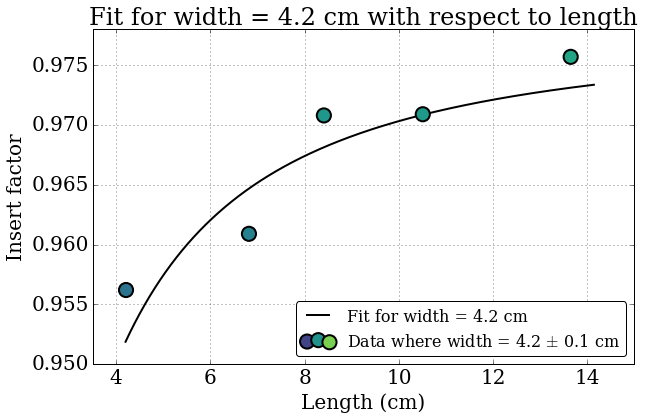

In [14]:
plt.figure(figsize=(6 * 1.618, 6))

specific_width = 4.2
specific_width = np.array([specific_width]*1000)

specific_width_length = np.linspace(specific_width[0], 10 * np.sqrt(2), 1000)
specific_width_eqPonA = to_eqPonA(specific_width, specific_width_length)

give_specific_width = fit_give(specific_width, specific_width_eqPonA, width, eqPonA, factor, kx=2, ky=1)
specific_width = specific_width[give_specific_width < 0.5]
specific_width_eqPonA = specific_width_eqPonA[give_specific_width < 0.5]
specific_width_length = specific_width_length[give_specific_width < 0.5]

specific_width_prediction = model(specific_width, specific_width_eqPonA)
plt.plot(specific_width_length, specific_width_prediction, 'k', lw=2, label=r'Fit for width = 4.2 cm')

specific_width_ref = np.abs(width - specific_width[0]) < 0.1

plt.scatter(
    length[specific_width_ref], factor[specific_width_ref], 
    s=200, lw=2,
    c=factor[specific_width_ref], cmap=green_cm, 
    vmin=vmin, vmax=vmax,
    zorder=3)

plt.scatter(
    [-1]*3, [-1]*3, s=200, lw=2,
    c=[green_cm(0.2), green_cm(0.5), green_cm(0.8)],
    zorder=3, 
    label=r'Data where width = 4.2 $\pm$ 0.1 cm')

plt.xlim([3.5, 15])
plt.ylim([0.95, 0.978])

plt.xlabel('Length (cm)')
plt.ylabel('Insert factor')
plt.title('Fit for width = 4.2 cm with respect to length')
legend = plt.legend(fancybox=True, loc='lower right')
legend.get_frame().set_facecolor('white')

plt.grid(True)

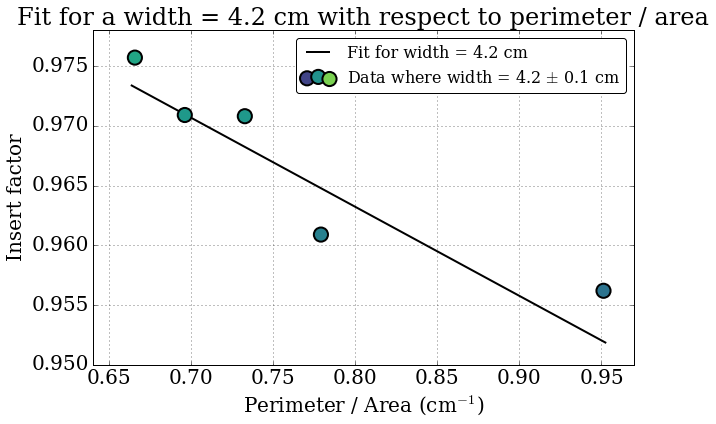

In [15]:
plt.figure(figsize=(6 * 1.618, 6))

specific_width = 4.2
specific_width = np.array([specific_width]*1000)

eqPonA_min = to_eqPonA(specific_width[0], 10 * np.sqrt(2))
eqPonA_max = to_eqPonA(specific_width[0], specific_width[0])
specific_width_eqPonA = np.linspace(eqPonA_min, eqPonA_max, 1000)

give_specific_width = fit_give(
    specific_width, specific_width_eqPonA, 
    width, eqPonA, factor, kx=2, ky=1)
specific_width = specific_width[give_specific_width < 0.5]
specific_width_eqPonA = specific_width_eqPonA[give_specific_width < 0.5]

specific_width_prediction = model(specific_width, specific_width_eqPonA)
plt.plot(
    specific_width_eqPonA, specific_width_prediction, 
    'k', lw=2, label=r'Fit for width = 4.2 cm')

specific_width_ref = np.abs(width - specific_width[0]) < 0.1


plt.scatter(
    eqPonA[specific_width_ref], factor[specific_width_ref],
    s=200, lw=2,
    c=factor[specific_width_ref], cmap=green_cm, 
    vmin=vmin, vmax=vmax,
    zorder=3)

plt.scatter(
    [-1]*3, [-1]*3, s=200, lw=2,
    c=[green_cm(0.2), green_cm(0.5), green_cm(0.8)],
    zorder=3, 
    label=r'Data where width = 4.2 $\pm$ 0.1 cm')

plt.xlim([0.64, 0.97])
plt.ylim([0.95, 0.978])



plt.xlabel('Perimeter / Area (cm$^{-1}$)')
plt.ylabel('Insert factor')
plt.title('Fit for a width = 4.2 cm with respect to perimeter / area')
legend = plt.legend(fancybox=True, loc='upper right')
legend.get_frame().set_facecolor('white')

plt.grid(True)